In [ ]:
import numpy as np
from src.plots import plot_class_score
from src.datasets import JetNetDataset
from src.train import ModelClassifierTest
from src.utils import GetConfigs
from src.architectures import DeepSets as deepsets

In [ ]:
path = 'tops.DeepSets.5feats.2class.1024batch.0.001lr'
config = GetConfigs(path=path + '/configs.json')
model = deepsets(model_config=config)
ref_class = 'flow_midpoint'

model

DeepSets(
  (criterion): CrossEntropyLoss()
  (wrapper): _DeepSets(
    (phi): Sequential(
      (0): Linear(in_features=5, out_features=256, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=256, out_features=256, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
    )
    (rho): Sequential(
      (0): Linear(in_features=512, out_features=256, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=256, out_features=256, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Linear(in_features=256, out_features=4, bias=True)
      (5): LeakyReLU(negative_slope=0.01)
    )
  )
)

In [ ]:

datasets = JetNetDataset(dir_path = 'data/', 
                        datasets = config.datasets,
                        class_labels = config.labels,
                        num_jets = config.size,
                        preprocess = config.preprocess,
                        particle_features = config.features,
                        )

classifier = ModelClassifierTest(classifier = model, 
                                datasets = datasets,
                                split_fractions = config.split_fractions,
                                epochs = config.epochs, 
                                lr = config.lr, 
                                early_stopping = config.early_stopping,
                                workdir = config.workdir,
                                seed = config.seed)

classifier.dataloader(batch_size=config.batch_size)
classifier.load_model(path=path + '/best_model.pth')
classifier.test(class_labels=config.labels)

INFO: loading and preprocessing data...
	- model 0: flow_midpoint  [fm_tops150_cond_mp200nfe.h5, etaphipt]  shape: torch.Size([266920, 150, 6])
	- model 1: diff_midpoint  [midpoint_100_csts.h5, etaphipt_frac]  shape: torch.Size([266920, 150, 6])
	- model 2: flow_euler  [fm_tops150_cond_eu200nfe.h5, etaphipt]  shape: torch.Size([266920, 150, 6])
	- model 3: diff_euler  [euler_200_csts.h5, etaphipt_frac]  shape: torch.Size([266920, 150, 6])
	- test : jetnet150  [t150.hdf5, particle_features]  shape: torch.Size([177945, 150, 6])
INFO: building dataloaders...
INFO: train/val/test split ratios: 0.5/0.2/0.3


testing:   0%|          | 0/365 [00:00<?, ?it/s]

/Users/dario/Dropbox/PROJECTS/ML/JetData/ClassifierMetric/src/architectures.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = torch.nn.functional.softmax(logits)


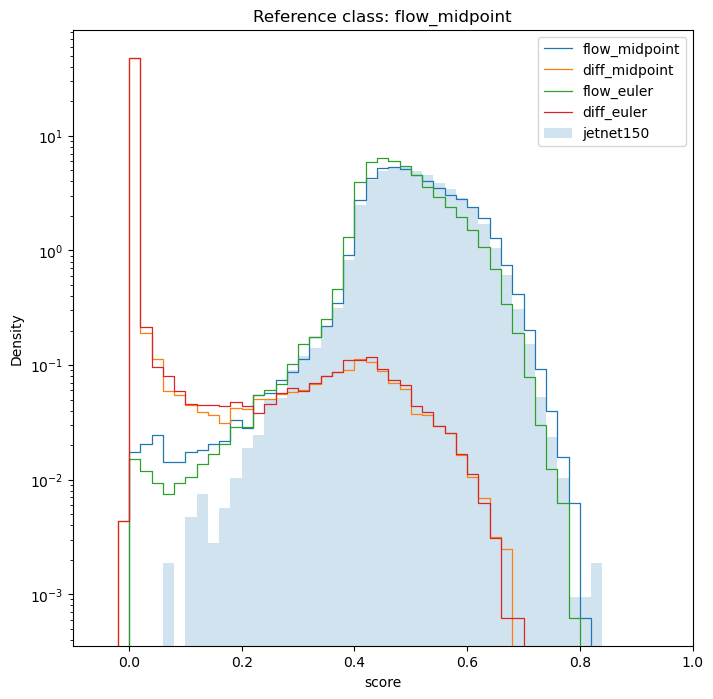

In [6]:
plot_class_score(predictions=classifier.predictions,
                class_labels=config.labels,
                reference=ref_class,
                workdir=config.workdir+'/results',
                figsize=(8,8), 
                xlim=(-.1,1), 
                lw=0.9,
                density=True,
                bins=np.arange(-0.1, 1.03, 0.02),
                legend_loc='upper right'
                )

In [7]:
classifier.predictions['datasets']

tensor([[4.0755e-01, 6.1830e-02, 4.7604e-01, 5.4576e-02, 3.0000e+00],
        [4.6825e-01, 7.4112e-05, 5.3160e-01, 8.1071e-05, 0.0000e+00],
        [5.9464e-01, 4.5044e-04, 4.0442e-01, 4.9339e-04, 0.0000e+00],
        ...,
        [4.7971e-01, 3.3056e-03, 5.1360e-01, 3.3772e-03, 0.0000e+00],
        [5.3143e-01, 3.4628e-05, 4.6850e-01, 3.8648e-05, 0.0000e+00],
        [1.3706e-05, 4.9756e-01, 1.3061e-05, 5.0242e-01, 1.0000e+00]])

In [ ]:
class JetNetPreprocess:
    
    def __init__(self, 
                 jet: torch.Tensor=None, 
                 method: dict=None, 
                 info: tuple=None):
        
        self.jet = jet
        self.dim_features = self.jet.shape[-1] - 1
        self.method = method
        self.mean, self.std, self.max, self.min = info
        self.mask = self.jet[:, -1, None]
        self.jet_unmask = self.jet[:, :self.dim_features]


    def standardize(self,  sigma: float=1.0):
        self.jet_unmask = (self.jet_unmask * self.mean) * (1e-8 + sigma / self.std )
        self.jet_unmask = self.jet_unmask * self.mask
        self.jet = torch.cat((self.jet_unmask, self.mask), dim=-1)

    def normalize(self):
        self.jet_unmask = (self.jet_unmask - self.min) / ( self.max - self.min )
        self.jet_unmask = self.jet_unmask * self.mask
        self.jet = torch.cat((self.jet_unmask, self.mask), dim=-1)
    
    def logit_tramsform(self, alpha=1e-6):
        self.jet_unmask = self.logit(self.jet_unmask, alpha=alpha)
        self.jet_unmask = self.jet_unmask * self.mask
        self.jet = torch.cat((self.jet_unmask, self.mask), dim=-1)

    def logit(t, alpha=1e-6):
        x = alpha + (1 - 2 * alpha) * t
        return torch.log(x/(1-x))

    # def normalize(self, inverse: bool=False):
    #     mask = self.particles[:, -1].bool()
    #     D = self.dim
    #     if not inverse:
    #         self.max, _ = torch.max(self.particles[..., :D][mask], dim=0, keepdim=True)
    #         self.min, _ = torch.min(self.particles[..., :D][mask], dim=0, keepdim=True)
    #         self.particles[..., :D][mask] = (self.particles[..., :D][mask] - self.min) / (self.max - self.min) 
    #         print('\t- normalizing data')
    #     else:
    #         self.particles[..., :D][mask] = self.particles[..., :D][mask] * (self.max - self.min) + self.min * mask 
    #         print('\t-: un-normalizing data')

    # def preprocess(self, methods: dict={}, name: str='data'):
    #     print('INFO: preprocessing {}'.format(name))
    #     method_items = list(methods.items())  
    #     for method_name, method_kwargs in method_items:
    #         method_kwargs['inverse'] = False
    #         method = getattr(self, method_name, None)
    #         if method and callable(method):
    #             method(**method_kwargs)
    #         else:
    #             print(f"Method {method_name} not found")



jet = data[0][0]
info = (torch.Tensor([ 1.8317e-05, -6.5716e-05,  1.5960e-02]), 
        torch.Tensor([0.1364, 0.1361, 0.0300]), 
        torch.Tensor([-3.1485e+00, -6.8031e-01,  2.0489e-08]), 
        torch.Tensor([1.6063, 0.8665, 0.9089]))

print(jet)
jet_prepr = JetPreprocess(jet, info=info)
jet_prepr.standardize(inverse=True, sigma=5.0)
# print(jet_prepr.jet)
jet_prepr.jet

In [ ]:
data[0][0]

# Jet images

In [ ]:
bins = (Bins(-1,1,200), Bins(-1,1,200))

jetnet.image(bins=bins) 
flowmatch.image(bins=bins)
diffusion.image(bins=bins)

# Check distribution of particle features

In [ ]:

data = JetNetDataLoader(dir_path='data/', 
                        data_files=DataConfig.sets,
                        preprocess=None,
                        num_jets=175000,
                        num_constituents=30, 
                        clip_neg_pt=True,
                        particle_features=['eta_rel', 'phi_rel', 'pt_rel', 'R', 'e_rel']
                        )

jetnet = JetNetFeatures(data[2])
flowmatch_mp = JetNetFeatures(data[0])
flowmatch_eu = JetNetFeatures(data[1])
diffusion = JetNetFeatures(data[3])

bins = Bins(0,1)
fig, ax = plt.subplots(1, figsize=(5,5))
jetnet.particle_plot(feature='pt_rel', bins=bins, ax=ax) 
flowmatch_eu.particle_plot(feature='pt_rel', bins=bins,  fill=False, color='r', ax=ax) 
flowmatch_mp.particle_plot(feature='pt_rel', bins=bins,  fill=False, color='purple', ax=ax) 
diffusion.particle_plot(feature='pt_rel', bins=bins, fill=False, color='b', ax=ax) 

bins = Bins(0,3)
fig, ax = plt.subplots(1, figsize=(5,5))
jetnet.particle_plot(feature='R', bins=bins, ax=ax) 
flowmatch_eu.particle_plot(feature='R', bins=bins,  fill=False, color='r', ax=ax) 
flowmatch_mp.particle_plot(feature='R', bins=bins,  fill=False, color='purple', ax=ax) 
diffusion.particle_plot(feature='R', bins=bins, fill=False, color='b', ax=ax) 

bins = Bins(0,0.8)
fig, ax = plt.subplots(1, figsize=(5,5))
jetnet.particle_plot(feature='pt_rel', nth_particle=1, bins=bins, ax=ax) 
flowmatch_eu.particle_plot(feature='pt_rel', nth_particle=1, bins=bins,  fill=False, color='r', ax=ax) 
flowmatch_mp.particle_plot(feature='pt_rel', nth_particle=1,bins=bins,  fill=False, color='purple', ax=ax) 
diffusion.particle_plot(feature='pt_rel', nth_particle=1, bins=bins, fill=False, color='b', ax=ax) 
plt.title(r'hardest particles in jet')

bins = Bins(0,0.35)
fig, ax = plt.subplots(1, figsize=(5,5))
jetnet.jet_plot(feature='m_rel', bins=bins, ax=ax) 
flowmatch_eu.jet_plot(feature='m_rel', bins=bins,  fill=False, color='r', ax=ax) 
flowmatch_mp.jet_plot(feature='m_rel', bins=bins,  fill=False, color='purple', ax=ax) 
diffusion.jet_plot(feature='m_rel', bins=bins, fill=False, color='b', ax=ax) 

bins = range(30)
fig, ax = plt.subplots(1, figsize=(5,5))
jetnet.jet_plot(feature='multiplicity', bins=bins, ax=ax) 
flowmatch_eu.jet_plot(feature='multiplicity', bins=bins,  fill=False, color='r', ax=ax) 
flowmatch_mp.jet_plot(feature='multiplicity', bins=bins,  fill=False, color='purple', ax=ax) 
diffusion.jet_plot(feature='multiplicity', bins=bins, fill=False, color='b', ax=ax) 

# Preprocess data

In [ ]:
data = JetNetDataLoader(dir_path='data/',  data_files=DataConfig.sets, preprocess=DataConfig.preprocess, num_jets=175000, num_constituents=30,  clip_neg_pt=True, particle_features=['eta_rel', 'phi_rel', 'pt_rel', 'R', 'e_rel'])

jetnet = JetNetFeatures(data[2])
flowmatch_mp = JetNetFeatures(data[0])
flowmatch_eu = JetNetFeatures(data[1])
diffusion = JetNetFeatures(data[3])

bins = Bins(-10,50)
fig, ax = plt.subplots(1, figsize=(5,5))
jetnet.particle_plot(feature='pt_rel', bins=bins, ax=ax) 
flowmatch_eu.particle_plot(feature='pt_rel', bins=bins,  fill=False, color='r', ax=ax) 
flowmatch_mp.particle_plot(feature='pt_rel', bins=bins,  fill=False, color='purple', ax=ax) 
diffusion.particle_plot(feature='pt_rel', bins=bins, fill=False, color='b', ax=ax) 

fig, ax = plt.subplots(1, figsize=(5,5))
jetnet.particle_plot(feature='R', bins=bins, ax=ax) 
flowmatch_eu.particle_plot(feature='R', bins=bins,  fill=False, color='r', ax=ax) 
flowmatch_mp.particle_plot(feature='R', bins=bins,  fill=False, color='purple', ax=ax) 
diffusion.particle_plot(feature='R', bins=bins, fill=False, color='b', ax=ax) 

fig, ax = plt.subplots(1, figsize=(5,5))
jetnet.particle_plot(feature='pt_rel', nth_particle=1, bins=bins, ax=ax) 
flowmatch_eu.particle_plot(feature='pt_rel', nth_particle=1, bins=bins,  fill=False, color='r', ax=ax) 
flowmatch_mp.particle_plot(feature='pt_rel', nth_particle=1,bins=bins,  fill=False, color='purple', ax=ax) 
diffusion.particle_plot(feature='pt_rel', nth_particle=1, bins=bins, fill=False, color='b', ax=ax) 
plt.title(r'hardest particles in jet')
